In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import bs4
import nltk
from numpy import asarray
import pickle
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from collections import Counter
from time import time 

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Dropout, Conv1D, MaxPooling1D, concatenate, Input, Flatten
import tensorflow as tf
from keras.models import Model
# from tensorflow.python.keras.callbacks import TensorBoard
# from keras.callbacks.tensorboard_v1 import TensorBoard
from keras.callbacks import TensorBoard
import keras

from scipy.sparse import hstack

Using TensorFlow backend.


## Reading Data

In [2]:
data = pd.read_csv('preprocessed_data.csv')

In [3]:
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [4]:
data.shape

(109248, 9)

In [5]:
X = data.loc[:,data.columns != 'project_is_approved']
y = data['project_is_approved']

In [6]:
print(X.shape, y.shape)

(109248, 8) (109248,)


## defining function to plot loss

In [7]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

## Splitting data into train, test and CV 

In [8]:
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.15, random_state=1, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_1, y_1, test_size=0.2, random_state=1, stratify=y_1);

## Converting y to one hot encoded vector

In [9]:
encoder = OneHotEncoder()
y_train = encoder.fit_transform(np.array(y_train).reshape(-1, 1))
y_test = encoder.transform(np.array(y_test).reshape(-1, 1))
y_cv = encoder.transform(np.array(y_cv).reshape(-1, 1))

y_train = y_train.toarray()
y_test = y_test.toarray()
y_cv = y_cv.toarray()

In [10]:
print(f'shape of output variable {y_train.shape}, {y_test.shape}, {y_cv.shape}')

shape of output variable (74288, 2), (16388, 2), (18572, 2)


## encoding Categorical Data

### encoding school_state 

In [11]:
school_states = data['school_state'].values
unique_states = list(set(school_states))

train_school_state = np.array([unique_states.index(school_state) for school_state in X_train['school_state'].values])
test_school_state = np.array([unique_states.index(school_state) for school_state in X_test['school_state'].values])
cv_school_state = np.array([unique_states.index(school_state) for school_state in X_cv['school_state'].values])

### encoding teacher prefix

In [12]:
teacher_prefix = data['teacher_prefix'].values
unique_teacher_prefix = list(set(teacher_prefix))

train_teacher_prefix = np.array([unique_teacher_prefix.index(teacher_prefix) for teacher_prefix in X_train['teacher_prefix'].values])
test_teacher_prefix = np.array([unique_teacher_prefix.index(teacher_prefix) for teacher_prefix in X_test['teacher_prefix'].values])
cv_teacher_prefix = np.array([unique_teacher_prefix.index(teacher_prefix) for teacher_prefix in X_cv['teacher_prefix'].values])


### encoding project_grade_category

In [13]:
project_grade_category = data['project_grade_category'].values
unique_project_grade_category = list(set(project_grade_category))

train_project_grade_category = np.array([unique_project_grade_category.index(project_grade_category) for project_grade_category in X_train['project_grade_category'].values])
test_project_grade_category = np.array([unique_project_grade_category.index(project_grade_category) for project_grade_category in X_test['project_grade_category'].values])
cv_project_grade_category = np.array([unique_project_grade_category.index(project_grade_category) for project_grade_category in X_cv['project_grade_category'].values])


### encoding clean_categories

In [14]:
#building vocab for category
my_counter = Counter()
for word in data['clean_categories'].values:
    my_counter.update(word.split())
    
cat_dict = dict(my_counter)
vocab_list_categories = [cat for cat, count in cat_dict.items()]

In [15]:

train_categories = []
max_cat_vector_len = 0
for text in X_train['clean_categories']:
    new_text = [vocab_list_categories.index(word)+1 for word in text.split()]
    train_categories.append(new_text)
    if len(new_text) > max_cat_vector_len:
        max_cat_vector_len = len(new_text)

test_categories = []
for text in X_test['clean_categories']:
    new_text = [vocab_list_categories.index(word)+1 for word in text.split()]
    test_categories.append(new_text)
    if len(new_text) > max_cat_vector_len:
        max_cat_vector_len = len(new_text)


cv_categories = []
for text in X_cv['clean_categories']:
    new_text = [vocab_list_categories.index(word)+1 for word in text.split()]
    cv_categories.append(new_text)
    if len(new_text) > max_cat_vector_len:
        max_cat_vector_len = len(new_text)

In [16]:
train_categories = sequence.pad_sequences(train_categories, maxlen = max_cat_vector_len)
test_categories = sequence.pad_sequences(test_categories, maxlen = max_cat_vector_len)
cv_categories = sequence.pad_sequences(cv_categories, maxlen=max_cat_vector_len)

### performing padding to make all encodings of same length

In [17]:

print(f'vector length => train: {len(train_categories[0])}, test: {len(test_categories[0])}, cv: {len(cv_categories[0])}')

vector length => train: 3, test: 3, cv: 3


### vectorizing clean_subcategories

In [18]:
#building vocab for subcategories
counter = Counter()
for word in data['clean_subcategories']:
    counter.update(word.split())
    
subcat_dict = dict(counter)
vocab_list_subcategories = [subcat for subcat, counts in subcat_dict.items()]

In [19]:
max_cat_vector_len = 0
train_subcategories = []
for text in X_train['clean_subcategories']:
    new_text = [vocab_list_subcategories.index(word)+1 for word in text.split()]
    train_subcategories.append(new_text)
    if len(new_text) > max_cat_vector_len:
        max_cat_vector_len = len(new_text)

test_subcategories = []
for text in X_test['clean_subcategories']:
    new_text = [vocab_list_subcategories.index(word)+1 for word in text.split()]
    test_subcategories.append(new_text)
    if len(new_text) > max_cat_vector_len:
        max_cat_vector_len = len(new_text)

cv_subcategories = []
for text in X_cv['clean_subcategories']:
    new_text = [vocab_list_subcategories.index(word)+1 for word in text.split()]
    cv_subcategories.append(new_text)
    if len(new_text) > max_cat_vector_len:
        max_cat_vector_len = len(new_text)


In [20]:
train_subcategories = sequence.pad_sequences(train_subcategories, maxlen = max_cat_vector_len)
test_subcategories = sequence.pad_sequences(test_subcategories, maxlen = max_cat_vector_len)
cv_subcategories = sequence.pad_sequences(cv_subcategories, maxlen = max_cat_vector_len)

## Encoding Numerical Data

### standardizing price

In [21]:
scaler = StandardScaler()

scaler.fit(X_train['price'].values.reshape(-1, 1))

train_price = scaler.transform(X_train['price'].values.reshape(-1, 1))
test_price = scaler.transform(X_test['price'].values.reshape(-1, 1))
cv_price = scaler.transform(X_cv['price'].values.reshape(-1, 1))

### teacher_number_of_previously_posted_projects

In [22]:
scaler = StandardScaler()

scaler.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

train_teacher_number = scaler.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
test_teacher_number = scaler.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))
cv_teacher_number = scaler.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

In [23]:
#combining price and np.concatenate((train_price, train_teacher_number), axis=1)
train_price_teacher = np.concatenate((train_price, train_teacher_number), axis=1)
test_price_teacher = np.concatenate((test_price, test_teacher_number), axis=1)
cv_price_teacher = np.concatenate((cv_price, cv_teacher_number), axis=1)

## Vectorizing essay using word2vec

### loading glove vector used to perform word2vec

In [24]:
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(X_train["essay"])
vocab_size = len(t.word_index) + 1
# integer encode the X_train["essay"]
encoded_docs_train = t.texts_to_sequences(X_train["essay"])
print(encoded_docs_train)
# pad documents to a max length of 500 words
max_length = 500
padded_docs_train = pad_sequences(encoded_docs_train, maxlen=max_length, padding='post')
print(padded_docs_train)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[[   4    1   90 ...    0    0    0]
 [ 210 2087    1 ...    0    0    0]
 [ 565    6   87 ...    0    0    0]
 ...
 [  46  489   99 ...    0    0    0]
 [   7    1   23 ...    0    0    0]
 [   4    1   19 ...    0    0    0]]


In [25]:
# integer encode the X_cv["essay"]
encoded_docs_cv = t.texts_to_sequences(X_cv["essay"])
padded_docs_cv = pad_sequences(encoded_docs_cv, maxlen=max_length, padding='post')
print(padded_docs_cv)

[[   2  211  206 ...    0    0    0]
 [   4    1 1016 ...    0    0    0]
 [ 351   30  635 ...    0    0    0]
 ...
 [   4   23   17 ...    0    0    0]
 [  46  343  708 ...    0    0    0]
 [  14  345  905 ...    0    0    0]]


In [26]:
# integer encode the X_test["essay"]
encoded_docs_test = t.texts_to_sequences(X_test["essay"])
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_length, padding='post')
print(padded_docs_test)

[[   2   49  954 ...    0    0    0]
 [   2   49  275 ...    0    0    0]
 [  25  168  215 ...    0    0    0]
 ...
 [   4    1  193 ...    0    0    0]
 [   2  124  767 ...    0    0    0]
 [ 737   94 1077 ...    0    0    0]]


In [27]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('./NLP/glove/glove.6B.300d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [28]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### defining epochs

In [29]:
epochs = 12

<h2>AUCROC For Keras</h2>

In [30]:
from keras import backend as K
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

## Model: 1

<img src='https://i.imgur.com/w395Yk9.png'>

ref: https://i.imgur.com/w395Yk9.png

In [31]:
#clearing the graph of tensorflow
keras.backend.clear_session()


#input_text branch
input_text_data = Input(shape=(500,), name='input_text_data')
embedding_essay = Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix], input_length=500, trainable=False)(input_text_data)
lstm_out = LSTM(100, return_sequences=True)(embedding_essay)
flatten = Flatten()(lstm_out)

#school_state_branch
school_state_features_size = 1
vocab_size = input_dim=len(unique_states)+1

input_school_state = Input(shape=(school_state_features_size,), name='input_school_state')
emb_state_data = Embedding(input_dim=vocab_size, output_dim=5, input_length=school_state_features_size)(input_school_state)
flatten_1 = Flatten()(emb_state_data)

#project_grade_category branch
pgc_features_size = 1
voacb_size = len(unique_project_grade_category)+1

input_pgc = Input(shape=(pgc_features_size, ), name='input_pgc')
emb_pgc_data = Embedding(input_dim=voacb_size, output_dim=5, input_length=pgc_features_size)(input_pgc)
flatten_2 = Flatten()(emb_pgc_data)

#clean_categories branch
categories_features_size = len(train_categories[0])
vocab_size = len(vocab_list_categories)+1

input_categories = Input(shape=(categories_features_size, ), name='input_categories')
emb_categories = Embedding(input_dim=vocab_size, output_dim=5, input_length=categories_features_size)(input_categories)
flatten_3 = Flatten()(emb_categories)

#clean_sub_categories branch
sub_categories_features_size = len(train_subcategories[0])
vocab_size = len(vocab_list_subcategories)+1

input_subcategories = Input(shape=(sub_categories_features_size, ), name='input_subcategories')
emb_subcategories = Embedding(input_dim=vocab_size, output_dim=5, input_length=sub_categories_features_size)(input_subcategories)
flatten_4 = Flatten()(emb_subcategories)

#teacher_prefix branch
teacher_prefix_feature_size = 1
vocab_size  = len(unique_teacher_prefix)+1

input_teacher_prefix = Input(shape=(teacher_prefix_feature_size, ), name='input_teacher_prefix')
emb_teacher_prefix = Embedding(input_dim=vocab_size, output_dim=5, input_length=teacher_prefix_feature_size)(input_teacher_prefix)
flatten_5 = Flatten()(emb_teacher_prefix)

#numeric data branch
no_of_features = 2
input_for_rem = Input(shape=(no_of_features,), name='input_for_rem')
dense_for_rem_input = Dense(10, activation="relu", input_shape=(no_of_features,), kernel_initializer="he_normal")(input_for_rem)

#concatenating
concated_data = concatenate([flatten, flatten_1, flatten_2, flatten_3, flatten_4, flatten_5, dense_for_rem_input])

#first dense layer
dense_1 = Dense(256, activation='relu', kernel_initializer='he_normal')(concated_data)
dropout = Dropout(0.3)(dense_1)

#second dense layer
dense_2 = Dense(128, activation='relu', kernel_initializer='he_normal')(dropout)
dropout_1 = Dropout(0.3)(dense_2)

#thrid dense layer
dense_3 =  Dense(64, activation='relu', kernel_initializer='he_normal')(dropout_1)

#softmax layer
output = Dense(2, activation='softmax')(dense_3)


model = Model(
    inputs=[input_text_data, input_school_state, 
            input_pgc, input_categories, 
            input_subcategories, input_teacher_prefix, 
            input_for_rem], 
    outputs=output)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_data (InputLayer)    (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 500, 300)     14511600    input_text_data[0][0]            
__________________________________________________________________________________________________
input_school_state (InputLayer) (None, 1)            0                                            
__________________________________________________________________________________________________
input_pgc (InputLayer)          (None, 1)            0                                            
____________________________________________________________________________________________

In [33]:
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy',auc])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


### Tensorboard configuration

In [34]:
log_dirs = "logs/{}".format(str(time()))

tensorboard = keras.callbacks.TensorBoard(log_dir=log_dirs)

In [35]:

history = model.fit(
    {
        'input_text_data': padded_docs_train, 
        'input_school_state':train_school_state, 
        'input_pgc':train_project_grade_category, 
        'input_categories':train_categories,
        'input_subcategories': train_subcategories,
        'input_teacher_prefix': train_teacher_prefix,
        'input_for_rem':train_price_teacher
    },
    y_train,
    nb_epoch=epochs, 
    batch_size=300,
    callbacks=[tensorboard],
    validation_data = (
        {
            'input_text_data':padded_docs_cv, 
            'input_school_state':cv_school_state, 
            'input_pgc':cv_project_grade_category, 
            'input_categories':cv_categories,
            'input_subcategories':cv_subcategories,
            'input_teacher_prefix':cv_teacher_prefix,
            'input_for_rem':cv_price_teacher
            },
        y_cv 
    ) 
)

Instructions for updating:
Use tf.cast instead.
Train on 74288 samples, validate on 18572 samples
Epoch 1/12


45300/74288 [=================>............] - ETA: 27:40 - loss: 0.8048 - acc: 0.1967 - auc: 0.18 - ETA: 24:23 - loss: 0.8784 - acc: 0.5333 - auc: 0.44 - ETA: 23:04 - loss: 0.7764 - acc: 0.6422 - auc: 0.55 - ETA: 22:22 - loss: 0.7754 - acc: 0.6192 - auc: 0.60 - ETA: 21:44 - loss: 0.7160 - acc: 0.6600 - auc: 0.64 - ETA: 21:15 - loss: 0.6699 - acc: 0.6922 - auc: 0.66 - ETA: 20:56 - loss: 0.6457 - acc: 0.7138 - auc: 0.68 - ETA: 20:43 - loss: 0.6230 - acc: 0.7308 - auc: 0.70 - ETA: 20:32 - loss: 0.6050 - acc: 0.7444 - auc: 0.71 - ETA: 20:23 - loss: 0.5912 - acc: 0.7540 - auc: 0.73 - ETA: 20:16 - loss: 0.5783 - acc: 0.7645 - auc: 0.74 - ETA: 20:07 - loss: 0.5726 - acc: 0.7669 - auc: 0.74 - ETA: 20:01 - loss: 0.5666 - acc: 0.7697 - auc: 0.75 - ETA: 19:54 - loss: 0.5588 - acc: 0.7743 - auc: 0.76 - ETA: 19:47 - loss: 0.5451 - acc: 0.7813 - auc: 0.76 - ETA: 19:50 - loss: 0.5397 - acc: 0.7844 - auc: 0.77 - ETA: 19:53 - loss: 0.5350 - acc: 0.7876 - auc: 0.77 - ETA: 19:47 - loss: 0.5290 - acc: 0.

45300/74288 [=================>............] - ETA: 26:26 - loss: 0.3774 - acc: 0.8433 - auc: 0.89 - ETA: 26:30 - loss: 0.3762 - acc: 0.8400 - auc: 0.89 - ETA: 26:29 - loss: 0.3527 - acc: 0.8522 - auc: 0.89 - ETA: 26:23 - loss: 0.3477 - acc: 0.8567 - auc: 0.89 - ETA: 26:17 - loss: 0.3502 - acc: 0.8573 - auc: 0.89 - ETA: 26:10 - loss: 0.3498 - acc: 0.8567 - auc: 0.89 - ETA: 26:02 - loss: 0.3714 - acc: 0.8495 - auc: 0.89 - ETA: 25:55 - loss: 0.3642 - acc: 0.8521 - auc: 0.89 - ETA: 25:50 - loss: 0.3567 - acc: 0.8574 - auc: 0.89 - ETA: 25:46 - loss: 0.3544 - acc: 0.8613 - auc: 0.89 - ETA: 25:39 - loss: 0.3509 - acc: 0.8609 - auc: 0.89 - ETA: 25:34 - loss: 0.3507 - acc: 0.8611 - auc: 0.89 - ETA: 25:27 - loss: 0.3460 - acc: 0.8641 - auc: 0.89 - ETA: 25:20 - loss: 0.3514 - acc: 0.8619 - auc: 0.89 - ETA: 25:13 - loss: 0.3517 - acc: 0.8624 - auc: 0.89 - ETA: 25:06 - loss: 0.3535 - acc: 0.8615 - auc: 0.89 - ETA: 25:00 - loss: 0.3554 - acc: 0.8616 - auc: 0.89 - ETA: 24:56 - loss: 0.3564 - acc: 0.

74288/74288 [==============================] - ETA: 11:02 - loss: 0.3713 - acc: 0.8538 - auc: 0.89 - ETA: 10:55 - loss: 0.3711 - acc: 0.8539 - auc: 0.89 - ETA: 10:48 - loss: 0.3708 - acc: 0.8541 - auc: 0.89 - ETA: 10:42 - loss: 0.3708 - acc: 0.8541 - auc: 0.89 - ETA: 10:35 - loss: 0.3708 - acc: 0.8541 - auc: 0.89 - ETA: 10:28 - loss: 0.3710 - acc: 0.8538 - auc: 0.89 - ETA: 10:21 - loss: 0.3712 - acc: 0.8538 - auc: 0.89 - ETA: 10:15 - loss: 0.3707 - acc: 0.8541 - auc: 0.89 - ETA: 10:08 - loss: 0.3709 - acc: 0.8539 - auc: 0.89 - ETA: 10:01 - loss: 0.3710 - acc: 0.8538 - auc: 0.89 - ETA: 9:54 - loss: 0.3710 - acc: 0.8538 - auc: 0.8980 - ETA: 9:48 - loss: 0.3709 - acc: 0.8538 - auc: 0.898 - ETA: 9:41 - loss: 0.3704 - acc: 0.8540 - auc: 0.898 - ETA: 9:34 - loss: 0.3705 - acc: 0.8540 - auc: 0.898 - ETA: 9:27 - loss: 0.3704 - acc: 0.8540 - auc: 0.898 - ETA: 9:20 - loss: 0.3704 - acc: 0.8541 - auc: 0.898 - ETA: 9:14 - loss: 0.3707 - acc: 0.8540 - auc: 0.898 - ETA: 9:07 - loss: 0.3707 - acc: 0.

45300/74288 [=================>............] - ETA: 30:05 - loss: 0.3582 - acc: 0.8633 - auc: 0.90 - ETA: 30:17 - loss: 0.3704 - acc: 0.8483 - auc: 0.90 - ETA: 30:18 - loss: 0.3439 - acc: 0.8633 - auc: 0.90 - ETA: 30:24 - loss: 0.3498 - acc: 0.8617 - auc: 0.90 - ETA: 30:28 - loss: 0.3420 - acc: 0.8640 - auc: 0.90 - ETA: 30:17 - loss: 0.3457 - acc: 0.8628 - auc: 0.90 - ETA: 30:05 - loss: 0.3449 - acc: 0.8610 - auc: 0.90 - ETA: 29:55 - loss: 0.3409 - acc: 0.8646 - auc: 0.90 - ETA: 29:48 - loss: 0.3375 - acc: 0.8652 - auc: 0.90 - ETA: 29:39 - loss: 0.3385 - acc: 0.8637 - auc: 0.90 - ETA: 29:27 - loss: 0.3374 - acc: 0.8652 - auc: 0.90 - ETA: 29:16 - loss: 0.3369 - acc: 0.8656 - auc: 0.90 - ETA: 29:07 - loss: 0.3415 - acc: 0.8641 - auc: 0.90 - ETA: 28:59 - loss: 0.3383 - acc: 0.8664 - auc: 0.90 - ETA: 28:51 - loss: 0.3389 - acc: 0.8653 - auc: 0.90 - ETA: 28:43 - loss: 0.3370 - acc: 0.8660 - auc: 0.90 - ETA: 28:33 - loss: 0.3369 - acc: 0.8661 - auc: 0.90 - ETA: 28:26 - loss: 0.3382 - acc: 0.

45300/74288 [=================>............] - ETA: 30:52 - loss: 0.2764 - acc: 0.8867 - auc: 0.91 - ETA: 30:37 - loss: 0.2889 - acc: 0.8800 - auc: 0.91 - ETA: 30:16 - loss: 0.2827 - acc: 0.8900 - auc: 0.91 - ETA: 30:02 - loss: 0.2738 - acc: 0.8942 - auc: 0.91 - ETA: 29:56 - loss: 0.2814 - acc: 0.8913 - auc: 0.91 - ETA: 29:51 - loss: 0.2818 - acc: 0.8906 - auc: 0.91 - ETA: 29:47 - loss: 0.2810 - acc: 0.8933 - auc: 0.91 - ETA: 29:35 - loss: 0.2815 - acc: 0.8917 - auc: 0.91 - ETA: 29:27 - loss: 0.2798 - acc: 0.8911 - auc: 0.91 - ETA: 29:19 - loss: 0.2823 - acc: 0.8903 - auc: 0.91 - ETA: 29:12 - loss: 0.2838 - acc: 0.8888 - auc: 0.91 - ETA: 29:03 - loss: 0.2836 - acc: 0.8897 - auc: 0.91 - ETA: 28:56 - loss: 0.2802 - acc: 0.8933 - auc: 0.91 - ETA: 28:49 - loss: 0.2856 - acc: 0.8905 - auc: 0.91 - ETA: 28:45 - loss: 0.2839 - acc: 0.8898 - auc: 0.91 - ETA: 28:37 - loss: 0.2840 - acc: 0.8896 - auc: 0.91 - ETA: 28:29 - loss: 0.2827 - acc: 0.8904 - auc: 0.91 - ETA: 28:21 - loss: 0.2826 - acc: 0.

74288/74288 [==============================] - ETA: 11:54 - loss: 0.2717 - acc: 0.8937 - auc: 0.91 - ETA: 11:46 - loss: 0.2719 - acc: 0.8936 - auc: 0.91 - ETA: 11:39 - loss: 0.2718 - acc: 0.8936 - auc: 0.91 - ETA: 11:31 - loss: 0.2720 - acc: 0.8935 - auc: 0.91 - ETA: 11:24 - loss: 0.2719 - acc: 0.8936 - auc: 0.91 - ETA: 11:16 - loss: 0.2719 - acc: 0.8936 - auc: 0.91 - ETA: 11:09 - loss: 0.2717 - acc: 0.8937 - auc: 0.91 - ETA: 11:02 - loss: 0.2715 - acc: 0.8937 - auc: 0.91 - ETA: 10:54 - loss: 0.2713 - acc: 0.8938 - auc: 0.91 - ETA: 10:47 - loss: 0.2714 - acc: 0.8937 - auc: 0.91 - ETA: 10:39 - loss: 0.2718 - acc: 0.8934 - auc: 0.91 - ETA: 10:32 - loss: 0.2719 - acc: 0.8934 - auc: 0.91 - ETA: 10:25 - loss: 0.2719 - acc: 0.8934 - auc: 0.91 - ETA: 10:17 - loss: 0.2721 - acc: 0.8934 - auc: 0.91 - ETA: 10:10 - loss: 0.2723 - acc: 0.8934 - auc: 0.91 - ETA: 10:02 - loss: 0.2724 - acc: 0.8933 - auc: 0.91 - ETA: 9:55 - loss: 0.2724 - acc: 0.8934 - auc: 0.9148 - ETA: 9:47 - loss: 0.2723 - acc: 0.

45300/74288 [=================>............] - ETA: 30:30 - loss: 0.1508 - acc: 0.9567 - auc: 0.91 - ETA: 30:25 - loss: 0.1527 - acc: 0.9600 - auc: 0.91 - ETA: 30:25 - loss: 0.1579 - acc: 0.9522 - auc: 0.91 - ETA: 30:24 - loss: 0.1717 - acc: 0.9467 - auc: 0.91 - ETA: 30:14 - loss: 0.1839 - acc: 0.9380 - auc: 0.91 - ETA: 30:01 - loss: 0.1798 - acc: 0.9417 - auc: 0.91 - ETA: 30:01 - loss: 0.1776 - acc: 0.9410 - auc: 0.91 - ETA: 29:50 - loss: 0.1836 - acc: 0.9362 - auc: 0.91 - ETA: 29:43 - loss: 0.1800 - acc: 0.9370 - auc: 0.91 - ETA: 29:36 - loss: 0.1781 - acc: 0.9373 - auc: 0.91 - ETA: 29:28 - loss: 0.1783 - acc: 0.9376 - auc: 0.91 - ETA: 29:19 - loss: 0.1787 - acc: 0.9378 - auc: 0.91 - ETA: 29:10 - loss: 0.1770 - acc: 0.9379 - auc: 0.91 - ETA: 29:05 - loss: 0.1752 - acc: 0.9393 - auc: 0.91 - ETA: 28:59 - loss: 0.1734 - acc: 0.9393 - auc: 0.91 - ETA: 28:52 - loss: 0.1735 - acc: 0.9396 - auc: 0.91 - ETA: 28:47 - loss: 0.1722 - acc: 0.9398 - auc: 0.91 - ETA: 28:42 - loss: 0.1702 - acc: 0.

45300/74288 [=================>............] - ETA: 30:59 - loss: 0.1228 - acc: 0.9567 - auc: 0.92 - ETA: 30:56 - loss: 0.1134 - acc: 0.9650 - auc: 0.92 - ETA: 30:37 - loss: 0.1143 - acc: 0.9689 - auc: 0.93 - ETA: 30:28 - loss: 0.1098 - acc: 0.9692 - auc: 0.93 - ETA: 30:22 - loss: 0.1037 - acc: 0.9707 - auc: 0.93 - ETA: 30:12 - loss: 0.1018 - acc: 0.9711 - auc: 0.93 - ETA: 30:03 - loss: 0.1023 - acc: 0.9705 - auc: 0.93 - ETA: 29:54 - loss: 0.0990 - acc: 0.9717 - auc: 0.93 - ETA: 29:47 - loss: 0.0999 - acc: 0.9700 - auc: 0.93 - ETA: 29:41 - loss: 0.0996 - acc: 0.9683 - auc: 0.93 - ETA: 29:33 - loss: 0.0972 - acc: 0.9691 - auc: 0.93 - ETA: 29:25 - loss: 0.0944 - acc: 0.9700 - auc: 0.93 - ETA: 29:16 - loss: 0.0908 - acc: 0.9710 - auc: 0.93 - ETA: 29:08 - loss: 0.0954 - acc: 0.9705 - auc: 0.93 - ETA: 29:02 - loss: 0.0940 - acc: 0.9704 - auc: 0.93 - ETA: 28:55 - loss: 0.0949 - acc: 0.9696 - auc: 0.93 - ETA: 28:47 - loss: 0.0945 - acc: 0.9688 - auc: 0.93 - ETA: 28:40 - loss: 0.0930 - acc: 0.

74288/74288 [==============================] - ETA: 11:58 - loss: 0.0927 - acc: 0.9675 - auc: 0.93 - ETA: 11:51 - loss: 0.0930 - acc: 0.9674 - auc: 0.93 - ETA: 11:43 - loss: 0.0934 - acc: 0.9672 - auc: 0.93 - ETA: 11:36 - loss: 0.0938 - acc: 0.9671 - auc: 0.93 - ETA: 11:29 - loss: 0.0942 - acc: 0.9671 - auc: 0.93 - ETA: 11:21 - loss: 0.0941 - acc: 0.9671 - auc: 0.93 - ETA: 11:14 - loss: 0.0941 - acc: 0.9671 - auc: 0.93 - ETA: 11:07 - loss: 0.0944 - acc: 0.9670 - auc: 0.93 - ETA: 11:00 - loss: 0.0945 - acc: 0.9670 - auc: 0.93 - ETA: 10:52 - loss: 0.0947 - acc: 0.9669 - auc: 0.93 - ETA: 10:45 - loss: 0.0947 - acc: 0.9668 - auc: 0.93 - ETA: 10:37 - loss: 0.0946 - acc: 0.9668 - auc: 0.93 - ETA: 10:30 - loss: 0.0949 - acc: 0.9668 - auc: 0.93 - ETA: 10:22 - loss: 0.0951 - acc: 0.9668 - auc: 0.93 - ETA: 10:15 - loss: 0.0952 - acc: 0.9667 - auc: 0.93 - ETA: 10:07 - loss: 0.0952 - acc: 0.9668 - auc: 0.93 - ETA: 9:59 - loss: 0.0955 - acc: 0.9667 - auc: 0.9349 - ETA: 9:52 - loss: 0.0954 - acc: 0.

45300/74288 [=================>............] - ETA: 31:01 - loss: 0.0800 - acc: 0.9800 - auc: 0.93 - ETA: 30:53 - loss: 0.0573 - acc: 0.9867 - auc: 0.93 - ETA: 30:44 - loss: 0.0546 - acc: 0.9844 - auc: 0.93 - ETA: 30:38 - loss: 0.0515 - acc: 0.9858 - auc: 0.93 - ETA: 30:41 - loss: 0.0483 - acc: 0.9853 - auc: 0.93 - ETA: 30:30 - loss: 0.0495 - acc: 0.9856 - auc: 0.93 - ETA: 30:29 - loss: 0.0501 - acc: 0.9848 - auc: 0.93 - ETA: 30:19 - loss: 0.0585 - acc: 0.9821 - auc: 0.93 - ETA: 30:10 - loss: 0.0684 - acc: 0.9815 - auc: 0.93 - ETA: 30:05 - loss: 0.0726 - acc: 0.9793 - auc: 0.93 - ETA: 29:56 - loss: 0.0729 - acc: 0.9788 - auc: 0.93 - ETA: 29:48 - loss: 0.0722 - acc: 0.9794 - auc: 0.93 - ETA: 29:38 - loss: 0.0708 - acc: 0.9800 - auc: 0.93 - ETA: 29:28 - loss: 0.0686 - acc: 0.9805 - auc: 0.93 - ETA: 29:22 - loss: 0.0681 - acc: 0.9804 - auc: 0.93 - ETA: 29:16 - loss: 0.0689 - acc: 0.9800 - auc: 0.93 - ETA: 29:11 - loss: 0.0678 - acc: 0.9802 - auc: 0.93 - ETA: 29:02 - loss: 0.0688 - acc: 0.

45300/74288 [=================>............] - ETA: 32:24 - loss: 0.0413 - acc: 0.9900 - auc: 0.94 - ETA: 31:29 - loss: 0.0351 - acc: 0.9867 - auc: 0.94 - ETA: 31:06 - loss: 0.0399 - acc: 0.9867 - auc: 0.94 - ETA: 30:47 - loss: 0.0414 - acc: 0.9867 - auc: 0.94 - ETA: 30:36 - loss: 0.0394 - acc: 0.9867 - auc: 0.94 - ETA: 30:28 - loss: 0.0353 - acc: 0.9878 - auc: 0.94 - ETA: 30:22 - loss: 0.0389 - acc: 0.9867 - auc: 0.94 - ETA: 30:18 - loss: 0.0445 - acc: 0.9863 - auc: 0.94 - ETA: 30:07 - loss: 0.0435 - acc: 0.9863 - auc: 0.94 - ETA: 30:00 - loss: 0.0414 - acc: 0.9873 - auc: 0.94 - ETA: 29:53 - loss: 0.0442 - acc: 0.9864 - auc: 0.94 - ETA: 29:45 - loss: 0.0414 - acc: 0.9875 - auc: 0.94 - ETA: 29:35 - loss: 0.0401 - acc: 0.9877 - auc: 0.94 - ETA: 29:24 - loss: 0.0413 - acc: 0.9876 - auc: 0.94 - ETA: 29:17 - loss: 0.0411 - acc: 0.9878 - auc: 0.94 - ETA: 29:11 - loss: 0.0407 - acc: 0.9879 - auc: 0.94 - ETA: 29:01 - loss: 0.0402 - acc: 0.9884 - auc: 0.94 - ETA: 28:53 - loss: 0.0404 - acc: 0.

74288/74288 [==============================] - ETA: 12:00 - loss: 0.0433 - acc: 0.9865 - auc: 0.94 - ETA: 11:52 - loss: 0.0437 - acc: 0.9864 - auc: 0.94 - ETA: 11:45 - loss: 0.0440 - acc: 0.9863 - auc: 0.94 - ETA: 11:37 - loss: 0.0439 - acc: 0.9863 - auc: 0.94 - ETA: 11:30 - loss: 0.0439 - acc: 0.9863 - auc: 0.94 - ETA: 11:22 - loss: 0.0442 - acc: 0.9862 - auc: 0.94 - ETA: 11:15 - loss: 0.0444 - acc: 0.9861 - auc: 0.94 - ETA: 11:07 - loss: 0.0445 - acc: 0.9861 - auc: 0.94 - ETA: 11:00 - loss: 0.0447 - acc: 0.9861 - auc: 0.94 - ETA: 10:52 - loss: 0.0448 - acc: 0.9861 - auc: 0.94 - ETA: 10:44 - loss: 0.0450 - acc: 0.9860 - auc: 0.94 - ETA: 10:37 - loss: 0.0451 - acc: 0.9860 - auc: 0.94 - ETA: 10:29 - loss: 0.0450 - acc: 0.9860 - auc: 0.94 - ETA: 10:22 - loss: 0.0453 - acc: 0.9860 - auc: 0.94 - ETA: 10:14 - loss: 0.0453 - acc: 0.9860 - auc: 0.94 - ETA: 10:07 - loss: 0.0455 - acc: 0.9859 - auc: 0.94 - ETA: 9:59 - loss: 0.0455 - acc: 0.9859 - auc: 0.9499 - ETA: 9:52 - loss: 0.0457 - acc: 0.

45300/74288 [=================>............] - ETA: 32:38 - loss: 0.0273 - acc: 0.9967 - auc: 0.95 - ETA: 31:39 - loss: 0.0218 - acc: 0.9933 - auc: 0.95 - ETA: 31:25 - loss: 0.0171 - acc: 0.9956 - auc: 0.95 - ETA: 31:04 - loss: 0.0238 - acc: 0.9933 - auc: 0.95 - ETA: 30:51 - loss: 0.0217 - acc: 0.9940 - auc: 0.95 - ETA: 30:42 - loss: 0.0214 - acc: 0.9933 - auc: 0.95 - ETA: 30:36 - loss: 0.0218 - acc: 0.9933 - auc: 0.95 - ETA: 30:27 - loss: 0.0215 - acc: 0.9933 - auc: 0.95 - ETA: 30:46 - loss: 0.0213 - acc: 0.9933 - auc: 0.95 - ETA: 30:33 - loss: 0.0204 - acc: 0.9937 - auc: 0.95 - ETA: 30:21 - loss: 0.0232 - acc: 0.9924 - auc: 0.95 - ETA: 30:14 - loss: 0.0241 - acc: 0.9919 - auc: 0.95 - ETA: 30:07 - loss: 0.0231 - acc: 0.9926 - auc: 0.95 - ETA: 29:57 - loss: 0.0232 - acc: 0.9924 - auc: 0.95 - ETA: 29:46 - loss: 0.0248 - acc: 0.9916 - auc: 0.95 - ETA: 29:37 - loss: 0.0258 - acc: 0.9913 - auc: 0.95 - ETA: 29:29 - loss: 0.0250 - acc: 0.9916 - auc: 0.95 - ETA: 29:21 - loss: 0.0248 - acc: 0.

45300/74288 [=================>............] - ETA: 31:39 - loss: 0.0356 - acc: 0.9833 - auc: 0.95 - ETA: 31:20 - loss: 0.0567 - acc: 0.9833 - auc: 0.95 - ETA: 31:18 - loss: 0.0510 - acc: 0.9867 - auc: 0.95 - ETA: 31:10 - loss: 0.0459 - acc: 0.9875 - auc: 0.95 - ETA: 31:00 - loss: 0.0473 - acc: 0.9860 - auc: 0.95 - ETA: 30:54 - loss: 0.0431 - acc: 0.9867 - auc: 0.95 - ETA: 30:47 - loss: 0.0389 - acc: 0.9881 - auc: 0.95 - ETA: 30:34 - loss: 0.0356 - acc: 0.9892 - auc: 0.95 - ETA: 30:22 - loss: 0.0345 - acc: 0.9893 - auc: 0.95 - ETA: 30:17 - loss: 0.0358 - acc: 0.9890 - auc: 0.95 - ETA: 30:08 - loss: 0.0339 - acc: 0.9894 - auc: 0.95 - ETA: 30:02 - loss: 0.0345 - acc: 0.9894 - auc: 0.95 - ETA: 29:55 - loss: 0.0348 - acc: 0.9892 - auc: 0.95 - ETA: 29:46 - loss: 0.0369 - acc: 0.9886 - auc: 0.95 - ETA: 29:38 - loss: 0.0374 - acc: 0.9889 - auc: 0.95 - ETA: 29:29 - loss: 0.0368 - acc: 0.9894 - auc: 0.95 - ETA: 29:21 - loss: 0.0355 - acc: 0.9898 - auc: 0.95 - ETA: 29:12 - loss: 0.0358 - acc: 0.

74288/74288 [==============================] - ETA: 12:04 - loss: 0.0316 - acc: 0.9905 - auc: 0.95 - ETA: 11:56 - loss: 0.0315 - acc: 0.9906 - auc: 0.95 - ETA: 11:48 - loss: 0.0315 - acc: 0.9906 - auc: 0.95 - ETA: 11:41 - loss: 0.0315 - acc: 0.9906 - auc: 0.95 - ETA: 11:33 - loss: 0.0316 - acc: 0.9906 - auc: 0.95 - ETA: 11:26 - loss: 0.0315 - acc: 0.9906 - auc: 0.95 - ETA: 11:18 - loss: 0.0314 - acc: 0.9907 - auc: 0.95 - ETA: 11:10 - loss: 0.0313 - acc: 0.9907 - auc: 0.95 - ETA: 11:03 - loss: 0.0313 - acc: 0.9907 - auc: 0.95 - ETA: 10:55 - loss: 0.0313 - acc: 0.9907 - auc: 0.95 - ETA: 10:48 - loss: 0.0312 - acc: 0.9907 - auc: 0.95 - ETA: 10:40 - loss: 0.0312 - acc: 0.9907 - auc: 0.95 - ETA: 10:33 - loss: 0.0311 - acc: 0.9908 - auc: 0.95 - ETA: 10:25 - loss: 0.0310 - acc: 0.9908 - auc: 0.95 - ETA: 10:17 - loss: 0.0312 - acc: 0.9907 - auc: 0.95 - ETA: 10:10 - loss: 0.0314 - acc: 0.9907 - auc: 0.95 - ETA: 10:02 - loss: 0.0319 - acc: 0.9906 - auc: 0.95 - ETA: 9:55 - loss: 0.0324 - acc: 0.9

45300/74288 [=================>............] - ETA: 30:57 - loss: 0.0261 - acc: 0.9900 - auc: 0.95 - ETA: 31:06 - loss: 0.0360 - acc: 0.9867 - auc: 0.95 - ETA: 30:49 - loss: 0.0332 - acc: 0.9889 - auc: 0.95 - ETA: 30:43 - loss: 0.0312 - acc: 0.9900 - auc: 0.95 - ETA: 30:34 - loss: 0.0338 - acc: 0.9900 - auc: 0.95 - ETA: 30:29 - loss: 0.0299 - acc: 0.9911 - auc: 0.95 - ETA: 30:22 - loss: 0.0286 - acc: 0.9914 - auc: 0.95 - ETA: 30:17 - loss: 0.0317 - acc: 0.9904 - auc: 0.95 - ETA: 30:12 - loss: 0.0305 - acc: 0.9911 - auc: 0.95 - ETA: 30:01 - loss: 0.0289 - acc: 0.9913 - auc: 0.95 - ETA: 29:51 - loss: 0.0291 - acc: 0.9912 - auc: 0.95 - ETA: 29:44 - loss: 0.0280 - acc: 0.9917 - auc: 0.95 - ETA: 29:38 - loss: 0.0264 - acc: 0.9923 - auc: 0.95 - ETA: 29:29 - loss: 0.0260 - acc: 0.9921 - auc: 0.95 - ETA: 29:26 - loss: 0.0257 - acc: 0.9924 - auc: 0.95 - ETA: 29:20 - loss: 0.0257 - acc: 0.9921 - auc: 0.95 - ETA: 29:13 - loss: 0.0258 - acc: 0.9920 - auc: 0.95 - ETA: 29:06 - loss: 0.0266 - acc: 0.

45300/74288 [=================>............] - ETA: 31:11 - loss: 0.0203 - acc: 0.9933 - auc: 0.96 - ETA: 31:12 - loss: 0.0258 - acc: 0.9933 - auc: 0.96 - ETA: 31:17 - loss: 0.0248 - acc: 0.9933 - auc: 0.96 - ETA: 31:24 - loss: 0.0272 - acc: 0.9917 - auc: 0.96 - ETA: 31:17 - loss: 0.0295 - acc: 0.9900 - auc: 0.96 - ETA: 31:06 - loss: 0.0343 - acc: 0.9894 - auc: 0.96 - ETA: 30:56 - loss: 0.0358 - acc: 0.9900 - auc: 0.96 - ETA: 30:46 - loss: 0.0324 - acc: 0.9913 - auc: 0.96 - ETA: 30:37 - loss: 0.0350 - acc: 0.9900 - auc: 0.96 - ETA: 30:28 - loss: 0.0337 - acc: 0.9903 - auc: 0.96 - ETA: 30:17 - loss: 0.0326 - acc: 0.9906 - auc: 0.96 - ETA: 30:07 - loss: 0.0303 - acc: 0.9914 - auc: 0.96 - ETA: 29:59 - loss: 0.0292 - acc: 0.9915 - auc: 0.96 - ETA: 29:54 - loss: 0.0291 - acc: 0.9914 - auc: 0.96 - ETA: 29:48 - loss: 0.0278 - acc: 0.9920 - auc: 0.96 - ETA: 29:38 - loss: 0.0265 - acc: 0.9925 - auc: 0.96 - ETA: 29:30 - loss: 0.0259 - acc: 0.9925 - auc: 0.96 - ETA: 29:21 - loss: 0.0252 - acc: 0.

74288/74288 [==============================] - ETA: 12:11 - loss: 0.0266 - acc: 0.9923 - auc: 0.96 - ETA: 12:03 - loss: 0.0266 - acc: 0.9923 - auc: 0.96 - ETA: 11:56 - loss: 0.0267 - acc: 0.9923 - auc: 0.96 - ETA: 11:48 - loss: 0.0267 - acc: 0.9923 - auc: 0.96 - ETA: 11:40 - loss: 0.0267 - acc: 0.9923 - auc: 0.96 - ETA: 11:33 - loss: 0.0267 - acc: 0.9923 - auc: 0.96 - ETA: 11:25 - loss: 0.0267 - acc: 0.9922 - auc: 0.96 - ETA: 11:17 - loss: 0.0266 - acc: 0.9922 - auc: 0.96 - ETA: 11:10 - loss: 0.0269 - acc: 0.9922 - auc: 0.96 - ETA: 11:02 - loss: 0.0271 - acc: 0.9922 - auc: 0.96 - ETA: 10:54 - loss: 0.0270 - acc: 0.9921 - auc: 0.96 - ETA: 10:47 - loss: 0.0270 - acc: 0.9921 - auc: 0.96 - ETA: 10:39 - loss: 0.0269 - acc: 0.9922 - auc: 0.96 - ETA: 10:32 - loss: 0.0270 - acc: 0.9921 - auc: 0.96 - ETA: 10:24 - loss: 0.0270 - acc: 0.9921 - auc: 0.96 - ETA: 10:16 - loss: 0.0269 - acc: 0.9922 - auc: 0.96 - ETA: 10:09 - loss: 0.0269 - acc: 0.9921 - auc: 0.96 - ETA: 10:01 - loss: 0.0268 - acc: 0.

In [36]:
model.metrics_names

['loss', 'acc', 'auc']

In [37]:
model1_score = model.evaluate({
        'input_text_data': padded_docs_test, 
        'input_school_state':test_school_state, 
        'input_pgc':test_project_grade_category, 
        'input_categories':test_categories,
        'input_subcategories': test_subcategories,
        'input_teacher_prefix': test_teacher_prefix,
        'input_for_rem':test_price_teacher
    },
    y_test, verbose=0)
model1_auc = model1_score[2]
model1_acc = model1_score[1]
print('Test auc:', model1_auc) 
print('Test accuracy:', model1_acc)

Test auc: 0.9629662860478603
Test accuracy: 0.8337808152306566


## Tensorboard Plots

<h2>AUC</h2>
<img src = "plots/model1_Auc.png">

<br/>
<h2>Accuracy</h2>
<img src="plots/model1_Acc.png">

<br/>
<h2>Loss</h2>
<img src="plots/model1_Loss.png">



## Model-2

- This model is similar to first model except that in essay we are selecting only few words based on idf value.
- we select words having idf score not very high and not very low.

In [31]:
#vectorizing using TfidfVectorizer, to obtain idf score and removing words having low and high idf, because very rare
#and very frequent word don't give much information
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['essay'])
feature_names = vectorizer.get_feature_names()
idf_score = list(vectorizer.idf_)

In [32]:
sorted_idf_score_index = np.argsort(idf_score) 
sorted_idf_score = sorted(idf_score)

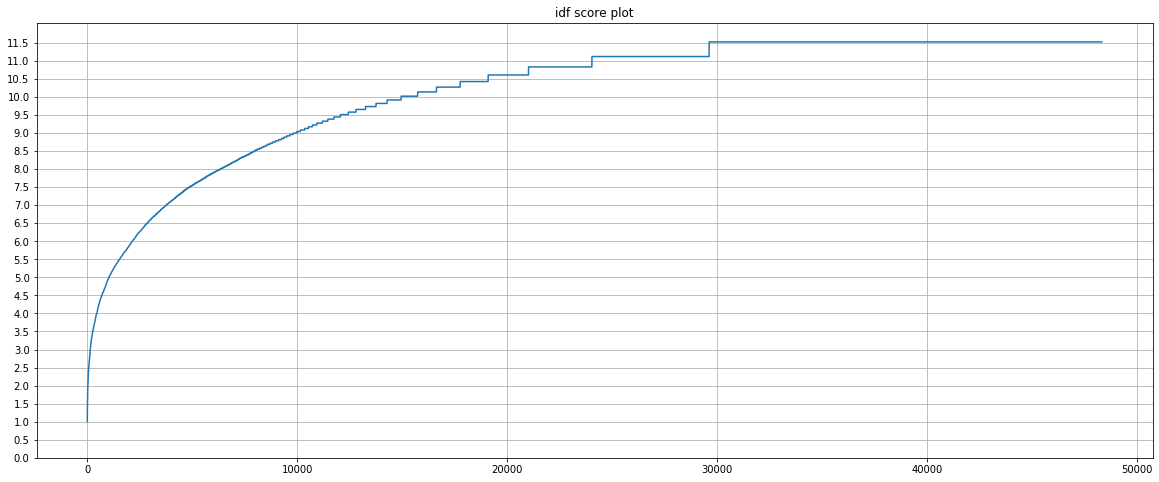

In [33]:
plt.figure(figsize=(20,8))
plt.plot(sorted_idf_score)
plt.yticks(np.arange(0, 12, 0.5))
plt.title('idf score plot')
plt.grid()

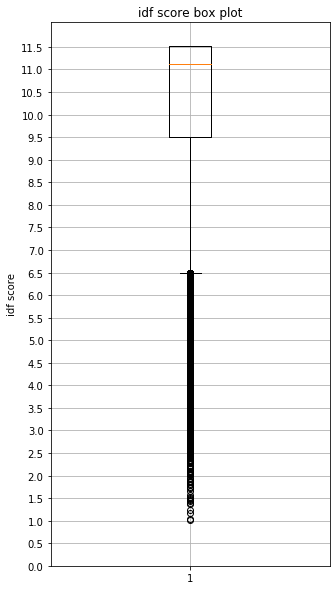

In [34]:
plt.figure(figsize=(5, 10))
plt.boxplot(idf_score)
plt.grid()
plt.yticks(np.arange(0,12,0.5))
plt.ylabel('idf score')
plt.title('idf score box plot')
plt.show()

In [35]:
#getting index of selected feature according to range of idf score
selected_features = []
for index, idf in enumerate(idf_score):
    if idf >= 9.5:
        selected_features.append(feature_names[index])

In [36]:
features_retain = len(selected_features)/len(feature_names) * 100.0
print(f'percentage of features retained: {features_retain}')

percentage of features retained: 75.05741181338574


## transforming essay, which contains only useful words

In [37]:
train_updated_essay = []
for sentence in tqdm(X_train['essay']):
    text = ' '.join([word for word in sentence.split() if word in selected_features])
    train_updated_essay.append(text)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 74288/74288 [2:37:04<00:00,  7.96it/s]


In [38]:
test_updated_essay = []
for sentence in tqdm(X_test['essay']):
    text = ' '.join([word for word in sentence.split() if word in selected_features])
    test_updated_essay.append(text)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 16388/16388 [37:08<00:00,  5.99it/s]


In [39]:
cv_updated_essay = []
for sentence in tqdm(X_cv['essay']):
    text = ' '.join([word for word in sentence.split() if word in selected_features])
    cv_updated_essay.append(text)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 18572/18572 [38:51<00:00,  7.97it/s]


## Tokeninzing essay

In [40]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_updated_essay)

vocab_size2 = len(tokenizer.word_index) + 1

train_essay_sequence = tokenizer.texts_to_sequences(train_updated_essay)

#padding essay to max length of 500 words
max_length = 500
padded_updated_essay_train = pad_sequences(train_essay_sequence, maxlen=max_length, padding='post')

In [41]:
test_essay_sequence = tokenizer.texts_to_sequences(test_updated_essay)

#padding
padded_updated_essay_test = pad_sequences(test_essay_sequence, maxlen=max_length, padding='post')

In [42]:
cv_essay_sequence = tokenizer.texts_to_sequences(cv_updated_essay)

#padding
padded_updated_essay_cv = pad_sequences(cv_essay_sequence, maxlen=max_length, padding='post')

In [43]:
vocab_size2

36280

In [44]:
len(tokenizer.word_index)

36279

In [45]:
# create a weight matrix for words in training docs
embedding_matrix2 = np.zeros((vocab_size2, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix2[i] = embedding_vector

In [46]:
#clearing the graph of tensorflow
keras.backend.clear_session()


#input_text branch
input_text_data = Input(shape=(500,), name='input_text_data')
embedding_essay = Embedding(input_dim=vocab_size2, output_dim=300, weights=[embedding_matrix2], input_length=500, trainable=False)(input_text_data)
lstm_out = LSTM(100, return_sequences=True)(embedding_essay)
flatten = Flatten()(lstm_out)

#school_state_branch
school_state_features_size = 1
vocab_size = input_dim=len(unique_states)+1

input_school_state = Input(shape=(school_state_features_size,), name='input_school_state')
emb_state_data = Embedding(input_dim=vocab_size, output_dim=5, input_length=school_state_features_size)(input_school_state)
flatten_1 = Flatten()(emb_state_data)

#project_grade_category branch
pgc_features_size = 1
voacb_size = len(unique_project_grade_category)+1

input_pgc = Input(shape=(pgc_features_size, ), name='input_pgc')
emb_pgc_data = Embedding(input_dim=voacb_size, output_dim=5, input_length=pgc_features_size)(input_pgc)
flatten_2 = Flatten()(emb_pgc_data)

#clean_categories branch
categories_features_size = len(train_categories[0])
vocab_size = len(vocab_list_categories)+1

input_categories = Input(shape=(categories_features_size, ), name='input_categories')
emb_categories = Embedding(input_dim=vocab_size, output_dim=5, input_length=categories_features_size)(input_categories)
flatten_3 = Flatten()(emb_categories)

#clean_sub_categories branch
sub_categories_features_size = len(train_subcategories[0])
vocab_size = len(vocab_list_subcategories)+1

input_subcategories = Input(shape=(sub_categories_features_size, ), name='input_subcategories')
emb_subcategories = Embedding(input_dim=vocab_size, output_dim=5, input_length=sub_categories_features_size)(input_subcategories)
flatten_4 = Flatten()(emb_subcategories)

#teacher_prefix branch
teacher_prefix_feature_size = 1
vocab_size  = len(unique_teacher_prefix)+1

input_teacher_prefix = Input(shape=(teacher_prefix_feature_size, ), name='input_teacher_prefix')
emb_teacher_prefix = Embedding(input_dim=vocab_size, output_dim=5, input_length=teacher_prefix_feature_size)(input_teacher_prefix)
flatten_5 = Flatten()(emb_teacher_prefix)

#numeric data branch
no_of_features = 2
input_for_rem = Input(shape=(no_of_features,), name='input_for_rem')
dense_for_rem_input = Dense(10, activation="relu", input_shape=(no_of_features,), kernel_initializer="he_normal")(input_for_rem)

#concatenating
concated_data = concatenate([flatten, flatten_1, flatten_2, flatten_3, flatten_4, flatten_5, dense_for_rem_input])

#first dense layer
dense_1 = Dense(256, activation='relu', kernel_initializer='he_normal')(concated_data)
dropout = Dropout(0.3)(dense_1)

#second dense layer
dense_2 = Dense(128, activation='relu', kernel_initializer='he_normal')(dropout)
dropout_1 = Dropout(0.3)(dense_2)

#thrid dense layer
dense_3 =  Dense(64, activation='relu', kernel_initializer='he_normal')(dropout_1)

#softmax layer
output = Dense(2, activation='softmax')(dense_3)


model2 = Model(
    inputs=[input_text_data, input_school_state, 
            input_pgc, input_categories, 
            input_subcategories, input_teacher_prefix, 
            input_for_rem], 
    outputs=output)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [47]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_data (InputLayer)    (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 500, 300)     10884000    input_text_data[0][0]            
__________________________________________________________________________________________________
input_school_state (InputLayer) (None, 1)            0                                            
__________________________________________________________________________________________________
input_pgc (InputLayer)          (None, 1)            0                                            
____________________________________________________________________________________________

In [48]:
model2.compile(optimizer="adam",loss='categorical_crossentropy',metrics=['accuracy',auc])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [67]:

history2 = model2.fit(
    {
        'input_text_data': padded_updated_essay_train, 
        'input_school_state':train_school_state, 
        'input_pgc':train_project_grade_category, 
        'input_categories':train_categories,
        'input_subcategories': train_subcategories,
        'input_teacher_prefix': train_teacher_prefix,
        'input_for_rem':train_price_teacher
    },
    y_train,
    nb_epoch=epochs, 
    batch_size=300,
    callbacks=[tensorboard],
    validation_data = (
        {
            'input_text_data':padded_updated_essay_cv, 
            'input_school_state':cv_school_state, 
            'input_pgc':cv_project_grade_category, 
            'input_categories':cv_categories,
            'input_subcategories':cv_subcategories,
            'input_teacher_prefix':cv_teacher_prefix,
            'input_for_rem':cv_price_teacher
            },
        y_cv 
    ) 
)

Train on 74288 samples, validate on 18572 samples
Epoch 1/12


45000/74288 [=================>............] - ETA: 58:03 - loss: 0.6966 - acc: 0.3167 - auc: 0.37 - ETA: 45:14 - loss: 0.6879 - acc: 0.5600 - auc: 0.51 - ETA: 42:11 - loss: 0.6443 - acc: 0.6589 - auc: 0.59 - ETA: 40:02 - loss: 0.5938 - acc: 0.7042 - auc: 0.64 - ETA: 38:45 - loss: 0.5678 - acc: 0.7373 - auc: 0.68 - ETA: 37:11 - loss: 0.5581 - acc: 0.7561 - auc: 0.70 - ETA: 36:14 - loss: 0.5404 - acc: 0.7676 - auc: 0.72 - ETA: 35:19 - loss: 0.5300 - acc: 0.7771 - auc: 0.74 - ETA: 34:31 - loss: 0.5220 - acc: 0.7863 - auc: 0.75 - ETA: 33:56 - loss: 0.5210 - acc: 0.7873 - auc: 0.76 - ETA: 33:27 - loss: 0.5156 - acc: 0.7927 - auc: 0.76 - ETA: 32:58 - loss: 0.5136 - acc: 0.7944 - auc: 0.77 - ETA: 32:39 - loss: 0.5024 - acc: 0.8008 - auc: 0.77 - ETA: 32:14 - loss: 0.5107 - acc: 0.7990 - auc: 0.78 - ETA: 31:51 - loss: 0.5061 - acc: 0.8022 - auc: 0.78 - ETA: 31:32 - loss: 0.4983 - acc: 0.8065 - auc: 0.79 - ETA: 31:13 - loss: 0.4913 - acc: 0.8114 - auc: 0.79 - ETA: 30:55 - loss: 0.4852 - acc: 0.

45300/74288 [=================>............] - ETA: 30:07 - loss: 0.3794 - acc: 0.8733 - auc: 0.86 - ETA: 30:40 - loss: 0.3919 - acc: 0.8667 - auc: 0.86 - ETA: 30:29 - loss: 0.4041 - acc: 0.8589 - auc: 0.86 - ETA: 30:26 - loss: 0.4218 - acc: 0.8492 - auc: 0.86 - ETA: 30:27 - loss: 0.4208 - acc: 0.8467 - auc: 0.86 - ETA: 30:17 - loss: 0.4143 - acc: 0.8483 - auc: 0.86 - ETA: 30:05 - loss: 0.4128 - acc: 0.8490 - auc: 0.86 - ETA: 29:59 - loss: 0.4109 - acc: 0.8496 - auc: 0.86 - ETA: 29:57 - loss: 0.4089 - acc: 0.8507 - auc: 0.86 - ETA: 29:52 - loss: 0.4137 - acc: 0.8483 - auc: 0.86 - ETA: 29:45 - loss: 0.4121 - acc: 0.8503 - auc: 0.86 - ETA: 29:37 - loss: 0.4107 - acc: 0.8506 - auc: 0.86 - ETA: 29:30 - loss: 0.4087 - acc: 0.8526 - auc: 0.86 - ETA: 29:21 - loss: 0.4092 - acc: 0.8524 - auc: 0.86 - ETA: 29:11 - loss: 0.4052 - acc: 0.8538 - auc: 0.86 - ETA: 29:03 - loss: 0.4085 - acc: 0.8523 - auc: 0.86 - ETA: 28:55 - loss: 0.4070 - acc: 0.8533 - auc: 0.86 - ETA: 28:46 - loss: 0.4077 - acc: 0.

74288/74288 [==============================] - ETA: 12:11 - loss: 0.4155 - acc: 0.8485 - auc: 0.87 - ETA: 12:04 - loss: 0.4157 - acc: 0.8483 - auc: 0.87 - ETA: 11:56 - loss: 0.4160 - acc: 0.8482 - auc: 0.87 - ETA: 11:49 - loss: 0.4161 - acc: 0.8482 - auc: 0.87 - ETA: 11:41 - loss: 0.4167 - acc: 0.8478 - auc: 0.87 - ETA: 11:33 - loss: 0.4169 - acc: 0.8477 - auc: 0.87 - ETA: 11:26 - loss: 0.4167 - acc: 0.8478 - auc: 0.87 - ETA: 11:18 - loss: 0.4164 - acc: 0.8480 - auc: 0.87 - ETA: 11:11 - loss: 0.4164 - acc: 0.8480 - auc: 0.87 - ETA: 11:03 - loss: 0.4164 - acc: 0.8481 - auc: 0.87 - ETA: 10:55 - loss: 0.4164 - acc: 0.8481 - auc: 0.87 - ETA: 10:48 - loss: 0.4164 - acc: 0.8481 - auc: 0.87 - ETA: 10:40 - loss: 0.4169 - acc: 0.8478 - auc: 0.87 - ETA: 10:32 - loss: 0.4170 - acc: 0.8478 - auc: 0.87 - ETA: 10:25 - loss: 0.4167 - acc: 0.8480 - auc: 0.87 - ETA: 10:17 - loss: 0.4167 - acc: 0.8480 - auc: 0.87 - ETA: 10:09 - loss: 0.4167 - acc: 0.8479 - auc: 0.87 - ETA: 10:01 - loss: 0.4168 - acc: 0.

45300/74288 [=================>............] - ETA: 30:48 - loss: 0.4096 - acc: 0.8433 - auc: 0.87 - ETA: 30:36 - loss: 0.4328 - acc: 0.8317 - auc: 0.87 - ETA: 30:43 - loss: 0.4330 - acc: 0.8356 - auc: 0.87 - ETA: 30:45 - loss: 0.4204 - acc: 0.8433 - auc: 0.87 - ETA: 30:35 - loss: 0.4206 - acc: 0.8440 - auc: 0.87 - ETA: 30:29 - loss: 0.4093 - acc: 0.8522 - auc: 0.87 - ETA: 30:20 - loss: 0.4131 - acc: 0.8490 - auc: 0.87 - ETA: 30:17 - loss: 0.4102 - acc: 0.8500 - auc: 0.87 - ETA: 30:11 - loss: 0.4020 - acc: 0.8541 - auc: 0.87 - ETA: 30:01 - loss: 0.4003 - acc: 0.8543 - auc: 0.87 - ETA: 29:51 - loss: 0.3991 - acc: 0.8552 - auc: 0.87 - ETA: 29:42 - loss: 0.3993 - acc: 0.8550 - auc: 0.87 - ETA: 29:34 - loss: 0.4010 - acc: 0.8546 - auc: 0.87 - ETA: 29:28 - loss: 0.3972 - acc: 0.8569 - auc: 0.87 - ETA: 29:22 - loss: 0.4015 - acc: 0.8549 - auc: 0.87 - ETA: 29:13 - loss: 0.4007 - acc: 0.8552 - auc: 0.87 - ETA: 29:04 - loss: 0.3969 - acc: 0.8576 - auc: 0.87 - ETA: 28:57 - loss: 0.3985 - acc: 0.

45300/74288 [=================>............] - ETA: 31:45 - loss: 0.3418 - acc: 0.8800 - auc: 0.87 - ETA: 31:30 - loss: 0.3726 - acc: 0.8683 - auc: 0.87 - ETA: 31:32 - loss: 0.3966 - acc: 0.8522 - auc: 0.87 - ETA: 31:16 - loss: 0.3948 - acc: 0.8542 - auc: 0.87 - ETA: 31:02 - loss: 0.3938 - acc: 0.8540 - auc: 0.87 - ETA: 30:56 - loss: 0.3971 - acc: 0.8522 - auc: 0.87 - ETA: 30:43 - loss: 0.4047 - acc: 0.8476 - auc: 0.87 - ETA: 30:31 - loss: 0.4150 - acc: 0.8400 - auc: 0.87 - ETA: 30:21 - loss: 0.4095 - acc: 0.8426 - auc: 0.87 - ETA: 30:19 - loss: 0.4131 - acc: 0.8410 - auc: 0.87 - ETA: 30:11 - loss: 0.4123 - acc: 0.8415 - auc: 0.87 - ETA: 30:03 - loss: 0.4134 - acc: 0.8411 - auc: 0.87 - ETA: 29:56 - loss: 0.4123 - acc: 0.8428 - auc: 0.87 - ETA: 29:45 - loss: 0.4153 - acc: 0.8414 - auc: 0.87 - ETA: 29:37 - loss: 0.4129 - acc: 0.8429 - auc: 0.87 - ETA: 29:28 - loss: 0.4133 - acc: 0.8421 - auc: 0.87 - ETA: 29:19 - loss: 0.4097 - acc: 0.8441 - auc: 0.87 - ETA: 29:13 - loss: 0.4089 - acc: 0.

74288/74288 [==============================] - ETA: 12:10 - loss: 0.4057 - acc: 0.8470 - auc: 0.87 - ETA: 12:03 - loss: 0.4057 - acc: 0.8469 - auc: 0.87 - ETA: 11:55 - loss: 0.4057 - acc: 0.8470 - auc: 0.87 - ETA: 11:47 - loss: 0.4055 - acc: 0.8470 - auc: 0.87 - ETA: 11:40 - loss: 0.4058 - acc: 0.8469 - auc: 0.87 - ETA: 11:32 - loss: 0.4057 - acc: 0.8469 - auc: 0.87 - ETA: 11:24 - loss: 0.4056 - acc: 0.8469 - auc: 0.87 - ETA: 11:17 - loss: 0.4056 - acc: 0.8470 - auc: 0.87 - ETA: 11:09 - loss: 0.4053 - acc: 0.8472 - auc: 0.87 - ETA: 11:01 - loss: 0.4053 - acc: 0.8472 - auc: 0.87 - ETA: 10:54 - loss: 0.4050 - acc: 0.8472 - auc: 0.87 - ETA: 10:46 - loss: 0.4048 - acc: 0.8473 - auc: 0.87 - ETA: 10:39 - loss: 0.4047 - acc: 0.8475 - auc: 0.87 - ETA: 10:31 - loss: 0.4047 - acc: 0.8475 - auc: 0.87 - ETA: 10:23 - loss: 0.4045 - acc: 0.8477 - auc: 0.87 - ETA: 10:16 - loss: 0.4044 - acc: 0.8477 - auc: 0.87 - ETA: 10:08 - loss: 0.4046 - acc: 0.8476 - auc: 0.87 - ETA: 10:00 - loss: 0.4045 - acc: 0.

45300/74288 [=================>............] - ETA: 33:25 - loss: 0.4307 - acc: 0.8333 - auc: 0.87 - ETA: 32:14 - loss: 0.3971 - acc: 0.8500 - auc: 0.87 - ETA: 31:38 - loss: 0.3984 - acc: 0.8478 - auc: 0.87 - ETA: 31:15 - loss: 0.4044 - acc: 0.8433 - auc: 0.87 - ETA: 31:02 - loss: 0.4020 - acc: 0.8467 - auc: 0.87 - ETA: 30:53 - loss: 0.4025 - acc: 0.8478 - auc: 0.87 - ETA: 30:51 - loss: 0.4042 - acc: 0.8467 - auc: 0.87 - ETA: 30:43 - loss: 0.3983 - acc: 0.8500 - auc: 0.87 - ETA: 30:34 - loss: 0.3955 - acc: 0.8504 - auc: 0.87 - ETA: 30:23 - loss: 0.3997 - acc: 0.8473 - auc: 0.87 - ETA: 30:14 - loss: 0.3981 - acc: 0.8485 - auc: 0.87 - ETA: 30:03 - loss: 0.3983 - acc: 0.8478 - auc: 0.87 - ETA: 29:54 - loss: 0.3953 - acc: 0.8497 - auc: 0.87 - ETA: 29:45 - loss: 0.3929 - acc: 0.8502 - auc: 0.87 - ETA: 29:37 - loss: 0.3940 - acc: 0.8500 - auc: 0.87 - ETA: 29:27 - loss: 0.3963 - acc: 0.8492 - auc: 0.87 - ETA: 29:19 - loss: 0.3922 - acc: 0.8516 - auc: 0.87 - ETA: 29:11 - loss: 0.3935 - acc: 0.

45300/74288 [=================>............] - ETA: 32:36 - loss: 0.3932 - acc: 0.8533 - auc: 0.88 - ETA: 32:05 - loss: 0.3752 - acc: 0.8633 - auc: 0.88 - ETA: 31:40 - loss: 0.3791 - acc: 0.8556 - auc: 0.88 - ETA: 31:26 - loss: 0.3765 - acc: 0.8567 - auc: 0.88 - ETA: 31:14 - loss: 0.3925 - acc: 0.8467 - auc: 0.88 - ETA: 31:17 - loss: 0.3821 - acc: 0.8528 - auc: 0.88 - ETA: 31:06 - loss: 0.3766 - acc: 0.8576 - auc: 0.88 - ETA: 30:54 - loss: 0.3724 - acc: 0.8608 - auc: 0.88 - ETA: 30:46 - loss: 0.3744 - acc: 0.8596 - auc: 0.88 - ETA: 30:39 - loss: 0.3710 - acc: 0.8610 - auc: 0.88 - ETA: 30:29 - loss: 0.3719 - acc: 0.8603 - auc: 0.88 - ETA: 30:20 - loss: 0.3725 - acc: 0.8597 - auc: 0.88 - ETA: 30:11 - loss: 0.3739 - acc: 0.8569 - auc: 0.88 - ETA: 30:00 - loss: 0.3738 - acc: 0.8555 - auc: 0.88 - ETA: 29:51 - loss: 0.3762 - acc: 0.8542 - auc: 0.88 - ETA: 29:41 - loss: 0.3800 - acc: 0.8519 - auc: 0.88 - ETA: 29:32 - loss: 0.3789 - acc: 0.8524 - auc: 0.88 - ETA: 29:25 - loss: 0.3782 - acc: 0.

74288/74288 [==============================] - ETA: 12:45 - loss: 0.3758 - acc: 0.8555 - auc: 0.88 - ETA: 12:37 - loss: 0.3755 - acc: 0.8557 - auc: 0.88 - ETA: 12:28 - loss: 0.3750 - acc: 0.8559 - auc: 0.88 - ETA: 12:20 - loss: 0.3753 - acc: 0.8558 - auc: 0.88 - ETA: 12:12 - loss: 0.3753 - acc: 0.8558 - auc: 0.88 - ETA: 12:04 - loss: 0.3752 - acc: 0.8559 - auc: 0.88 - ETA: 11:56 - loss: 0.3753 - acc: 0.8559 - auc: 0.88 - ETA: 11:47 - loss: 0.3753 - acc: 0.8559 - auc: 0.88 - ETA: 11:39 - loss: 0.3752 - acc: 0.8560 - auc: 0.88 - ETA: 11:31 - loss: 0.3751 - acc: 0.8560 - auc: 0.88 - ETA: 11:23 - loss: 0.3755 - acc: 0.8559 - auc: 0.88 - ETA: 11:15 - loss: 0.3753 - acc: 0.8560 - auc: 0.88 - ETA: 11:07 - loss: 0.3754 - acc: 0.8560 - auc: 0.88 - ETA: 10:58 - loss: 0.3752 - acc: 0.8561 - auc: 0.88 - ETA: 10:50 - loss: 0.3752 - acc: 0.8561 - auc: 0.88 - ETA: 10:42 - loss: 0.3752 - acc: 0.8562 - auc: 0.88 - ETA: 10:34 - loss: 0.3754 - acc: 0.8561 - auc: 0.88 - ETA: 10:26 - loss: 0.3755 - acc: 0.

45300/74288 [=================>............] - ETA: 30:59 - loss: 0.4226 - acc: 0.8167 - auc: 0.88 - ETA: 30:55 - loss: 0.3756 - acc: 0.8467 - auc: 0.88 - ETA: 30:52 - loss: 0.3845 - acc: 0.8444 - auc: 0.88 - ETA: 30:47 - loss: 0.3738 - acc: 0.8533 - auc: 0.88 - ETA: 30:38 - loss: 0.3709 - acc: 0.8520 - auc: 0.88 - ETA: 30:36 - loss: 0.3656 - acc: 0.8539 - auc: 0.88 - ETA: 30:24 - loss: 0.3601 - acc: 0.8581 - auc: 0.88 - ETA: 30:16 - loss: 0.3620 - acc: 0.8562 - auc: 0.88 - ETA: 30:09 - loss: 0.3634 - acc: 0.8581 - auc: 0.88 - ETA: 30:02 - loss: 0.3663 - acc: 0.8560 - auc: 0.88 - ETA: 29:58 - loss: 0.3625 - acc: 0.8579 - auc: 0.88 - ETA: 29:49 - loss: 0.3648 - acc: 0.8564 - auc: 0.88 - ETA: 29:42 - loss: 0.3640 - acc: 0.8567 - auc: 0.88 - ETA: 29:35 - loss: 0.3639 - acc: 0.8555 - auc: 0.88 - ETA: 29:30 - loss: 0.3644 - acc: 0.8549 - auc: 0.88 - ETA: 29:23 - loss: 0.3637 - acc: 0.8556 - auc: 0.88 - ETA: 29:15 - loss: 0.3628 - acc: 0.8557 - auc: 0.88 - ETA: 29:11 - loss: 0.3616 - acc: 0.

45300/74288 [=================>............] - ETA: 31:58 - loss: 0.3637 - acc: 0.8500 - auc: 0.88 - ETA: 31:34 - loss: 0.3333 - acc: 0.8733 - auc: 0.88 - ETA: 31:24 - loss: 0.3260 - acc: 0.8744 - auc: 0.88 - ETA: 31:27 - loss: 0.3267 - acc: 0.8725 - auc: 0.88 - ETA: 31:26 - loss: 0.3215 - acc: 0.8760 - auc: 0.88 - ETA: 31:11 - loss: 0.3274 - acc: 0.8717 - auc: 0.88 - ETA: 31:04 - loss: 0.3292 - acc: 0.8724 - auc: 0.88 - ETA: 30:57 - loss: 0.3285 - acc: 0.8729 - auc: 0.88 - ETA: 30:45 - loss: 0.3279 - acc: 0.8722 - auc: 0.88 - ETA: 30:34 - loss: 0.3288 - acc: 0.8710 - auc: 0.88 - ETA: 30:23 - loss: 0.3258 - acc: 0.8752 - auc: 0.88 - ETA: 30:14 - loss: 0.3292 - acc: 0.8733 - auc: 0.88 - ETA: 30:05 - loss: 0.3280 - acc: 0.8744 - auc: 0.88 - ETA: 29:58 - loss: 0.3300 - acc: 0.8738 - auc: 0.88 - ETA: 29:48 - loss: 0.3304 - acc: 0.8727 - auc: 0.88 - ETA: 29:40 - loss: 0.3321 - acc: 0.8715 - auc: 0.88 - ETA: 29:32 - loss: 0.3286 - acc: 0.8745 - auc: 0.88 - ETA: 29:23 - loss: 0.3294 - acc: 0.

74288/74288 [==============================] - ETA: 12:12 - loss: 0.3341 - acc: 0.8711 - auc: 0.88 - ETA: 12:04 - loss: 0.3345 - acc: 0.8709 - auc: 0.88 - ETA: 11:57 - loss: 0.3345 - acc: 0.8710 - auc: 0.88 - ETA: 11:49 - loss: 0.3346 - acc: 0.8709 - auc: 0.88 - ETA: 11:41 - loss: 0.3350 - acc: 0.8706 - auc: 0.88 - ETA: 11:34 - loss: 0.3352 - acc: 0.8706 - auc: 0.88 - ETA: 11:26 - loss: 0.3352 - acc: 0.8705 - auc: 0.88 - ETA: 11:19 - loss: 0.3354 - acc: 0.8704 - auc: 0.88 - ETA: 11:11 - loss: 0.3359 - acc: 0.8702 - auc: 0.88 - ETA: 11:04 - loss: 0.3360 - acc: 0.8701 - auc: 0.88 - ETA: 10:56 - loss: 0.3357 - acc: 0.8702 - auc: 0.88 - ETA: 10:48 - loss: 0.3356 - acc: 0.8703 - auc: 0.88 - ETA: 10:41 - loss: 0.3355 - acc: 0.8703 - auc: 0.88 - ETA: 10:33 - loss: 0.3357 - acc: 0.8702 - auc: 0.88 - ETA: 10:25 - loss: 0.3354 - acc: 0.8704 - auc: 0.88 - ETA: 10:18 - loss: 0.3355 - acc: 0.8704 - auc: 0.88 - ETA: 10:10 - loss: 0.3359 - acc: 0.8702 - auc: 0.88 - ETA: 10:02 - loss: 0.3354 - acc: 0.

45300/74288 [=================>............] - ETA: 30:54 - loss: 0.3463 - acc: 0.8567 - auc: 0.89 - ETA: 30:38 - loss: 0.3375 - acc: 0.8667 - auc: 0.89 - ETA: 30:59 - loss: 0.3190 - acc: 0.8789 - auc: 0.89 - ETA: 30:56 - loss: 0.3124 - acc: 0.8842 - auc: 0.89 - ETA: 30:54 - loss: 0.3244 - acc: 0.8780 - auc: 0.89 - ETA: 30:45 - loss: 0.3241 - acc: 0.8783 - auc: 0.89 - ETA: 30:38 - loss: 0.3183 - acc: 0.8810 - auc: 0.89 - ETA: 30:27 - loss: 0.3156 - acc: 0.8817 - auc: 0.89 - ETA: 30:22 - loss: 0.3187 - acc: 0.8804 - auc: 0.89 - ETA: 30:20 - loss: 0.3173 - acc: 0.8797 - auc: 0.89 - ETA: 30:15 - loss: 0.3148 - acc: 0.8809 - auc: 0.89 - ETA: 30:10 - loss: 0.3103 - acc: 0.8825 - auc: 0.89 - ETA: 30:03 - loss: 0.3130 - acc: 0.8821 - auc: 0.89 - ETA: 29:55 - loss: 0.3146 - acc: 0.8810 - auc: 0.89 - ETA: 29:46 - loss: 0.3177 - acc: 0.8796 - auc: 0.89 - ETA: 29:39 - loss: 0.3179 - acc: 0.8794 - auc: 0.89 - ETA: 29:29 - loss: 0.3163 - acc: 0.8806 - auc: 0.89 - ETA: 29:20 - loss: 0.3154 - acc: 0.

45300/74288 [=================>............] - ETA: 31:15 - loss: 0.3238 - acc: 0.8700 - auc: 0.89 - ETA: 31:11 - loss: 0.3084 - acc: 0.8767 - auc: 0.89 - ETA: 30:56 - loss: 0.3065 - acc: 0.8811 - auc: 0.89 - ETA: 30:43 - loss: 0.3156 - acc: 0.8775 - auc: 0.89 - ETA: 30:33 - loss: 0.3091 - acc: 0.8813 - auc: 0.89 - ETA: 30:27 - loss: 0.3085 - acc: 0.8828 - auc: 0.89 - ETA: 30:19 - loss: 0.3014 - acc: 0.8871 - auc: 0.89 - ETA: 30:09 - loss: 0.3023 - acc: 0.8867 - auc: 0.89 - ETA: 30:05 - loss: 0.3094 - acc: 0.8822 - auc: 0.89 - ETA: 30:03 - loss: 0.3090 - acc: 0.8813 - auc: 0.89 - ETA: 30:13 - loss: 0.3079 - acc: 0.8824 - auc: 0.89 - ETA: 30:15 - loss: 0.3053 - acc: 0.8831 - auc: 0.89 - ETA: 30:07 - loss: 0.3080 - acc: 0.8815 - auc: 0.89 - ETA: 29:57 - loss: 0.3060 - acc: 0.8833 - auc: 0.89 - ETA: 29:48 - loss: 0.3036 - acc: 0.8844 - auc: 0.89 - ETA: 29:39 - loss: 0.3054 - acc: 0.8829 - auc: 0.89 - ETA: 29:30 - loss: 0.3012 - acc: 0.8847 - auc: 0.89 - ETA: 29:21 - loss: 0.3011 - acc: 0.

74288/74288 [==============================] - ETA: 12:13 - loss: 0.3094 - acc: 0.8804 - auc: 0.89 - ETA: 12:05 - loss: 0.3094 - acc: 0.8804 - auc: 0.89 - ETA: 11:58 - loss: 0.3093 - acc: 0.8805 - auc: 0.89 - ETA: 11:50 - loss: 0.3089 - acc: 0.8807 - auc: 0.89 - ETA: 11:42 - loss: 0.3090 - acc: 0.8807 - auc: 0.89 - ETA: 11:35 - loss: 0.3093 - acc: 0.8806 - auc: 0.89 - ETA: 11:27 - loss: 0.3094 - acc: 0.8805 - auc: 0.89 - ETA: 11:19 - loss: 0.3091 - acc: 0.8806 - auc: 0.89 - ETA: 11:12 - loss: 0.3092 - acc: 0.8805 - auc: 0.89 - ETA: 11:04 - loss: 0.3093 - acc: 0.8803 - auc: 0.89 - ETA: 10:57 - loss: 0.3093 - acc: 0.8804 - auc: 0.89 - ETA: 10:49 - loss: 0.3089 - acc: 0.8806 - auc: 0.89 - ETA: 10:42 - loss: 0.3086 - acc: 0.8808 - auc: 0.89 - ETA: 10:34 - loss: 0.3085 - acc: 0.8808 - auc: 0.89 - ETA: 10:26 - loss: 0.3086 - acc: 0.8808 - auc: 0.89 - ETA: 10:19 - loss: 0.3089 - acc: 0.8807 - auc: 0.89 - ETA: 10:11 - loss: 0.3088 - acc: 0.8808 - auc: 0.89 - ETA: 10:04 - loss: 0.3092 - acc: 0.

45300/74288 [=================>............] - ETA: 32:18 - loss: 0.2746 - acc: 0.8967 - auc: 0.89 - ETA: 31:49 - loss: 0.2684 - acc: 0.8983 - auc: 0.89 - ETA: 31:23 - loss: 0.2795 - acc: 0.8911 - auc: 0.89 - ETA: 31:03 - loss: 0.2784 - acc: 0.8917 - auc: 0.89 - ETA: 30:49 - loss: 0.2850 - acc: 0.8887 - auc: 0.89 - ETA: 30:39 - loss: 0.2809 - acc: 0.8911 - auc: 0.89 - ETA: 30:31 - loss: 0.2863 - acc: 0.8881 - auc: 0.89 - ETA: 30:23 - loss: 0.2860 - acc: 0.8867 - auc: 0.89 - ETA: 30:15 - loss: 0.2862 - acc: 0.8881 - auc: 0.89 - ETA: 30:05 - loss: 0.2846 - acc: 0.8893 - auc: 0.89 - ETA: 29:58 - loss: 0.2886 - acc: 0.8879 - auc: 0.89 - ETA: 29:51 - loss: 0.2882 - acc: 0.8883 - auc: 0.89 - ETA: 29:43 - loss: 0.2908 - acc: 0.8867 - auc: 0.89 - ETA: 29:37 - loss: 0.2942 - acc: 0.8845 - auc: 0.89 - ETA: 29:28 - loss: 0.2920 - acc: 0.8862 - auc: 0.89 - ETA: 29:21 - loss: 0.2912 - acc: 0.8871 - auc: 0.89 - ETA: 29:14 - loss: 0.2930 - acc: 0.8865 - auc: 0.89 - ETA: 29:06 - loss: 0.2930 - acc: 0.

45300/74288 [=================>............] - ETA: 32:46 - loss: 0.2238 - acc: 0.9133 - auc: 0.90 - ETA: 33:53 - loss: 0.2544 - acc: 0.9000 - auc: 0.90 - ETA: 32:47 - loss: 0.2713 - acc: 0.8933 - auc: 0.90 - ETA: 32:18 - loss: 0.2594 - acc: 0.9017 - auc: 0.90 - ETA: 32:11 - loss: 0.2724 - acc: 0.8967 - auc: 0.90 - ETA: 31:48 - loss: 0.2738 - acc: 0.8944 - auc: 0.90 - ETA: 31:30 - loss: 0.2747 - acc: 0.8948 - auc: 0.90 - ETA: 31:17 - loss: 0.2766 - acc: 0.8937 - auc: 0.90 - ETA: 31:05 - loss: 0.2748 - acc: 0.8948 - auc: 0.90 - ETA: 30:51 - loss: 0.2751 - acc: 0.8943 - auc: 0.90 - ETA: 30:39 - loss: 0.2761 - acc: 0.8930 - auc: 0.90 - ETA: 30:29 - loss: 0.2721 - acc: 0.8950 - auc: 0.90 - ETA: 30:19 - loss: 0.2740 - acc: 0.8944 - auc: 0.90 - ETA: 30:11 - loss: 0.2760 - acc: 0.8931 - auc: 0.90 - ETA: 30:00 - loss: 0.2762 - acc: 0.8922 - auc: 0.90 - ETA: 29:51 - loss: 0.2736 - acc: 0.8931 - auc: 0.90 - ETA: 29:43 - loss: 0.2732 - acc: 0.8933 - auc: 0.90 - ETA: 29:34 - loss: 0.2715 - acc: 0.

74288/74288 [==============================] - ETA: 12:13 - loss: 0.2816 - acc: 0.8910 - auc: 0.90 - ETA: 12:06 - loss: 0.2819 - acc: 0.8908 - auc: 0.90 - ETA: 11:58 - loss: 0.2818 - acc: 0.8909 - auc: 0.90 - ETA: 11:50 - loss: 0.2819 - acc: 0.8908 - auc: 0.90 - ETA: 11:43 - loss: 0.2820 - acc: 0.8908 - auc: 0.90 - ETA: 11:35 - loss: 0.2818 - acc: 0.8909 - auc: 0.90 - ETA: 11:27 - loss: 0.2818 - acc: 0.8910 - auc: 0.90 - ETA: 11:20 - loss: 0.2819 - acc: 0.8910 - auc: 0.90 - ETA: 11:12 - loss: 0.2822 - acc: 0.8909 - auc: 0.90 - ETA: 11:04 - loss: 0.2820 - acc: 0.8910 - auc: 0.90 - ETA: 10:57 - loss: 0.2816 - acc: 0.8912 - auc: 0.90 - ETA: 10:49 - loss: 0.2813 - acc: 0.8915 - auc: 0.90 - ETA: 10:41 - loss: 0.2813 - acc: 0.8915 - auc: 0.90 - ETA: 10:33 - loss: 0.2813 - acc: 0.8915 - auc: 0.90 - ETA: 10:26 - loss: 0.2815 - acc: 0.8914 - auc: 0.90 - ETA: 10:18 - loss: 0.2814 - acc: 0.8915 - auc: 0.90 - ETA: 10:10 - loss: 0.2816 - acc: 0.8914 - auc: 0.90 - ETA: 10:02 - loss: 0.2818 - acc: 0.

In [69]:
padded_updated_essay_cv.shape

(18572, 500)

In [49]:
model2_score = model2.evaluate({
        'input_text_data': padded_updated_essay_test, 
        'input_school_state':test_school_state, 
        'input_pgc':test_project_grade_category, 
        'input_categories':test_categories,
        'input_subcategories': test_subcategories,
        'input_teacher_prefix': test_teacher_prefix,
        'input_for_rem':test_price_teacher
    },
    y_test, verbose=0)
model2_auc = model2_score[2]
model2_acc = model2_score[1]
print('Test auc:', model2_auc) 
print('Test accuracy:', model2_acc)

Test auc: 0.1896140930389002
Test accuracy: 0.1850744447156456


## Model - 3

### Vectorizing school_state

In [ ]:
vectorizer = CountVectorizer(binary=True)
train_school_state = vectorizer.fit_transform(X_train['school_state'].values)
test_school_state = vectorizerrizerorizerorizerorizer.transform(X_test['school_state'].values)
cv_school_state = vectorizer.transform(X_cv['school_state'].values)

### Vectorizing teacher_prefix

In [ ]:
vectorizer = CountVectorizer(binary=True)
train_teacher_prefix = vectorizer.fit_transform(X_train['teacher_prefix'].values)
test_teacher_prefix = vectorizer.transform(X_test['teacher_prefix'].values)
cv_teacher_prefix = vectorizer.transform(X_cv['teacher_prefix'].values)

### Vectorizing project_grade_category

In [ ]:
vectorizer = CountVectorizer(binary=True)
train_pgc = vectorizer.fit_transform(X_train['project_grade_category'].values)
test_pgc = vectorizer.transform(X_test['project_grade_category'].values)
cv_pgc = vectorizer.transform(X_cv['project_grade_category'].values)

### Vectorizing categories

In [ ]:
vectorizer = CountVectorizer(binary=True, vocabulary=list(cat_dict.keys()))
train_categories = vectorizer.fit_transform(X_train['clean_categories'].values)
test_categories = vectorizer.transform(X_test['clean_categories'].values)
cv_categories = vectorizer.transform(X_cv['clean_categories'].values)

### Vectorizing subcategories

In [ ]:
vectorizer = CountVectorizer(binary=True, vocabulary=list(subcat_dict.keys()))
train_subcategories = vectorizer.fit_transform(X_train['clean_subcategories'].values)
test_subcategories = vectorizer.transform(X_test['clean_subcategories'].values)
cv_subcategories = vectorizer.transform(X_cv['clean_subcategories'].values)

###  merging all features

In [ ]:
train_rem_features = hstack((train_school_state, train_teacher_prefix, train_pgc, train_categories, train_subcategories, train_price, train_teacher_number)).tocsr()
test_rem_features = hstack((test_school_state, test_teacher_prefix, test_pgc, test_categories, test_subcategories, test_price, test_teacher_number)).tocsr()
cv_rem_features = hstack((cv_school_state, cv_teacher_prefix, cv_pgc, cv_categories, cv_subcategories, cv_price, cv_teacher_number)).tocsr()

In [ ]:
print(train_rem_features.shape, y_train.shape)
print(test_rem_features.shape, y_cv.shape)
print(cv_rem_features.shape, y_test.shape)

### building model

In [ ]:
keras.backend.clear_session()

#input_text branch
input_text_data = Input(shape=(500,), name='input_text_data')
embedding_essay = Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix], input_length=500, trainable=False)(input_text_data)
lstm_out = LSTM(100, return_sequences=True)(embedding_essay)
flatten = Flatten()(lstm_out)

#remaining input branch
input_rem_data = Input(shape=(train_rem_features.shape[1],), name='input_rem_data')
conv_1 = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(input_rem_data)
conv_2 = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(conv_1)
flatten_2 = Flatten()(conv_2)

#concatenating
concated_data = concatenate([flatten, flatten_2])

#first dense layer
dense_1 = Dense(256, activation='relu', kernel_initializer='he_normal')(concated_data)
dropout = Dropout(0.3)(dense_1)

#second dense layer
dense_2 = Dense(128, activation='relu', kernel_initializer='he_normal')(dropout)
dropout_1 = Dropout(0.3)(dense_2)

#thrid dense layer
dense_3 =  Dense(64, activation='relu', kernel_initializer='he_normal')(dropout_1)

#softmax layer
output = Dense(2, activation='softmax')(dense_3)

model3 = Model(
    inputs=[input_text_data, input_rem_data], 
    outputs=output)

In [ ]:
model3.summary()